# FLIGHT PRICE PREDICTION

### Importing necessarry libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics

## Scraped Data EDA: <a class="anchor" id="eda"></a>
### Loading the scraped data

In [2]:
df_1 = pd.read_csv("/Users/vishnudinesh/Desktop/data/PAR_NYC.csv")
df_2 = pd.read_csv("/Users/vishnudinesh/Desktop/data/PAR_SVO.csv")
df_3 = pd.read_csv("/Users/vishnudinesh/Desktop/data/SVO_NYC.csv")
df_4 = pd.read_csv("/Users/vishnudinesh/Desktop/data/SVO_RUH.csv")
df_5 = pd.read_csv("/Users/vishnudinesh/Desktop/data/NYC_PAR.csv")
df_6 = pd.read_csv("/Users/vishnudinesh/Desktop/data/NYC_SVO.csv")
df_7 = pd.read_csv("/Users/vishnudinesh/Desktop/data/RUH_NYC.csv")
df_8 = pd.read_csv("/Users/vishnudinesh/Desktop/data/RUH_PAR.csv")
df_9 = pd.read_csv("/Users/vishnudinesh/Desktop/data/RUH_SVO.csv")
df_10 = pd.read_csv("/Users/vishnudinesh/Desktop/data/SVO_PAR.csv")
df_11 = pd.read_csv("/Users/vishnudinesh/Desktop/data/PAR_RUH.csv")
df_12 = pd.read_csv("/Users/vishnudinesh/Desktop/data/NYC_RUH.csv")

In [3]:
print(f"{df_1['Source'][0]} => {df_1['Destination'][0]} route has {df_1.shape[0]} trips")
print(f"{df_2['Source'][0]} => {df_2['Destination'][0]} route has {df_2.shape[0]} trips")
print(f"{df_3['Source'][0]} => {df_3['Destination'][0]} route has {df_3.shape[0]} trips")
print(f"{df_4['Source'][0]} => {df_4['Destination'][0]} route has {df_4.shape[0]} trips")
print(f"{df_5['Source'][0]} => {df_5['Destination'][0]} route has {df_5.shape[0]} trips")
print(f"{df_6['Source'][0]} => {df_6['Destination'][0]} route has {df_6.shape[0]} trips")
print(f"{df_7['Source'][0]} => {df_7['Destination'][0]} route has {df_7.shape[0]} trips")
print(f"{df_8['Source'][0]} => {df_8['Destination'][0]} route has {df_8.shape[0]} trips")
print(f"{df_9['Source'][0]} => {df_9['Destination'][0]} route has {df_9.shape[0]} trips")
print(f"{df_10['Source'][0]} => {df_10['Destination'][0]} route has {df_10.shape[0]} trips")
print(f"{df_11['Source'][0]} => {df_11['Destination'][0]} route has {df_11.shape[0]} trips")
print(f"{df_12['Source'][0]} => {df_12['Destination'][0]} route has {df_12.shape[0]} trips")

PAR => NYC route has 14881 trips
PAR => SVO route has 2403 trips
SVO => NYC route has 4202 trips
SVO => RUH route has 2235 trips
NYC => PAR route has 5334 trips
NYC => SVO route has 1905 trips
RUH => NYC route has 7279 trips
RUH => PAR route has 553 trips
RUH => SVO route has 2725 trips
SVO => PAR route has 3314 trips
PAR => RUH route has 7327 trips
NYC => RUH route has 3205 trips


### Defining functions to clean the data

In [4]:
# convert duration to numerical format in minutes
def clean_duration(duration):
    duration = list(duration)
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(duration[i].split(sep = "h")[0])) # Extract hours from duration
        duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1])) # Extracts only minutes from duration

    d = []
    for i in range(len(duration)):
        d.append(duration_hours[i]*60+duration_mins[i])
        
    return d

# convert price to numerical format in USD
def clean_price(price):
    price = price.str.replace(',','',regex=True)
    price = price.str.replace('SAR','',regex=True)
    price = price.str.strip()
    price = round(pd.to_numeric(price)/3.75,2)
    return price

# convert date to datetime format
def clean_date(date):
    date = pd.to_datetime(date)
    return date

# get price quantile to deal with outliers
def get_price_quantile(price):
    Q1 = price.quantile(0.25)
    Q3 = price.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5 * IQR
    upper_lim = Q3 + 1.5 * IQR
    return (lower_lim,upper_lim)

# get average of each airline
def get_avg_per_airline(x):
    # average for trips with multiple airlines
    multiple_airlines = x[x["Airline"].str.contains(",")]
    b = list(multiple_airlines["Airline"].str.split(","))
    d = [] # Airline 1
    e = [] # Airline 2
    for i in range(len(b)):
        d.append(b[i][0])
        e.append(b[i][1])
    for i in range(len(e)):
        e[i] = e[i].strip()
    m_airlines = list(set(d)) + list(set(e))
    column_names = ["Airline", "Average Price"]
    t_ = pd.DataFrame(columns = column_names)
    for airline in m_airlines:
        t = pd.DataFrame(x[x["Airline"].str.contains(airline)]["Airline"])
        t["Average Price"] = x[x["Airline"].str.contains(airline)]["Price"].mean()
        t_ = t_.append(t)
    t__ = t_.groupby("Airline",as_index = False)["Average Price"].mean()
    k = multiple_airlines.copy()
    k = k.merge(t__, on = "Airline", how = "left")
    
    # average for trips with single airlines
    single_airlines = x[~x["Airline"].str.contains(",")]
    avg_per_airline = single_airlines.groupby("Airline", as_index = False)["Price"].mean()
    avg_per_airline = avg_per_airline.rename(columns={"Price" : "Average Price"})
    temp = single_airlines.copy()
    temp = temp.merge(avg_per_airline, on='Airline', how ="left")
    
    temp_1 = temp.groupby("Airline", as_index = False)["Average Price"].mean()
    k_1 = k.groupby("Airline", as_index = False)["Average Price"].mean()
    k_temp = pd.concat([k_1,temp_1])
    y = x.merge(k_temp, on = "Airline")
    
    return y


In [5]:
dfs_raw = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12]

In [6]:
# cleaning the data
dfs = []
for df in dfs_raw:
    df.drop_duplicates() # drop duplicate rows
    df["Duration"] = clean_duration(df["Duration"]) # convert duration to numerical minutes format
    df["Price"] = clean_price(df["Price"]) # convert price to numerical format in USD
    df["Date"] = clean_date(df["Date"]) # convert date to datetime format
    dfs.append(get_avg_per_airline(df)) # get average per airline


### Studying outliers

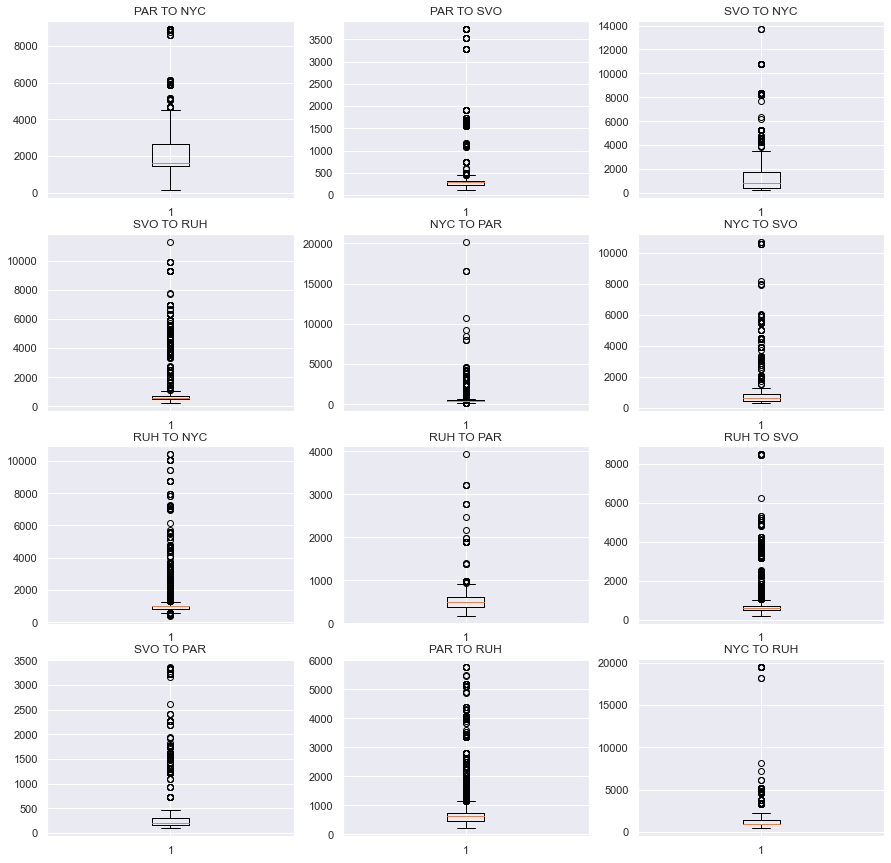

In [7]:
# boxplots for each route
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### It is apparent that all routes have outliers, so we'll deal with them by IQR

In [8]:
# get quantile to deal with outliers
lower = []
upper = []
for df in dfs:
    x = get_price_quantile(df['Price'])
    lower.append(x[0])
    upper.append(x[1])

In [9]:
# drop outliers
k = 0
for df in dfs:
    low = df['Price'] < lower[k]
    up = df['Price'] > upper[k]
    df['Price'] = df['Price'][~(low|up)]
    df.dropna(inplace=True)
    df.reset_index(drop = True,inplace=True)
    k+=1

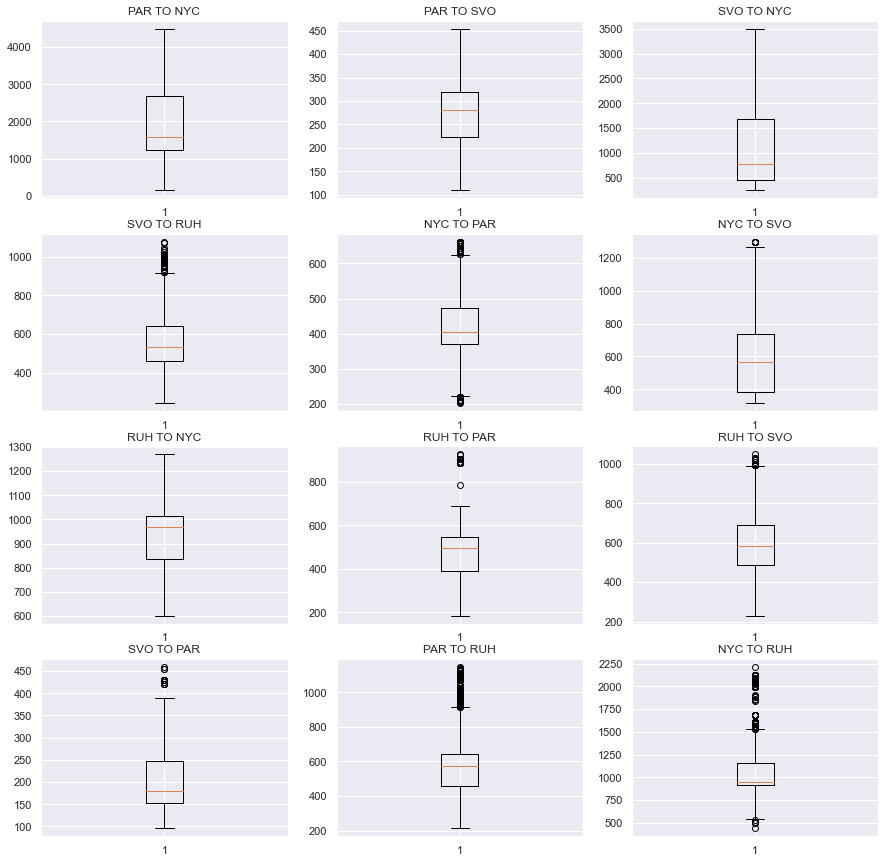

In [10]:
# boxplot for each route after dealing with outliers
k=0
figure, axis = plt.subplots(4, 3, figsize=(15,15))
for i in range(4):
    for j in range(3):
        axis[i,j].boxplot(dfs[k]['Price'])
        axis[i,j].set_title(f"{dfs[k]['Source'][0]} TO {dfs[k]['Destination'][0]}")
        k += 1

#### Now the data is much better, the total dropped data is 5,266 rows out of 55,363.

In [11]:
# concat all routes into one dataframe
df = pd.concat(dfs)
df

,Airline,Source,Destination,Duration,Total stops,Price,Date,Average Price
0,TAP AIR PORTUGAL,PAR,NYC,770,1 stop,379.47,2022-02-01,441.343760
1,TAP AIR PORTUGAL,PAR,NYC,770,1 stop,379.47,2022-02-01,441.343760
2,TAP AIR PORTUGAL,PAR,NYC,810,1 stop,379.47,2022-02-01,441.343760
3,TAP AIR PORTUGAL,PAR,NYC,890,1 stop,379.47,2022-02-01,441.343760
4,TAP AIR PORTUGAL,PAR,NYC,1030,1 stop,379.47,2022-02-01,441.343760
...,...,...,...,...,...,...,...,...
3046,"SAS, Pegasus Airlines",NYC,RUH,1300,2 stops,930.40,2022-04-13,838.732500
3047,"Qatar Airways, SAUDIA",NYC,RUH,1420,2 stops,1018.40,2022-04-13,1972.813714
3048,"Qatar Airways, MEA",NYC,RUH,1415,2 stops,1049.87,2022-04-13,1133.548015
3049,"Emirates, Turkish Airlines",NYC,RUH,1100,2 stops,1053.60,2022-04-13,1023.900221


In [12]:
# check for null values
df.isnull().sum()

Airline          0
Source           0
Destination      0
Duration         0
Total stops      0
Price            0
Date             0
Average Price    0
dtype: int64

## Handling Categorical Data: <a class="anchor" id="cat_data"></a>


In [13]:
# the Airline column will be replaced by the average price per airline.
df.drop("Airline", axis = 1, inplace = True)

In [14]:
# source
df["Source"].value_counts()

PAR    23054
NYC     9411
RUH     9140
SVO     8492
Name: Source, dtype: int64

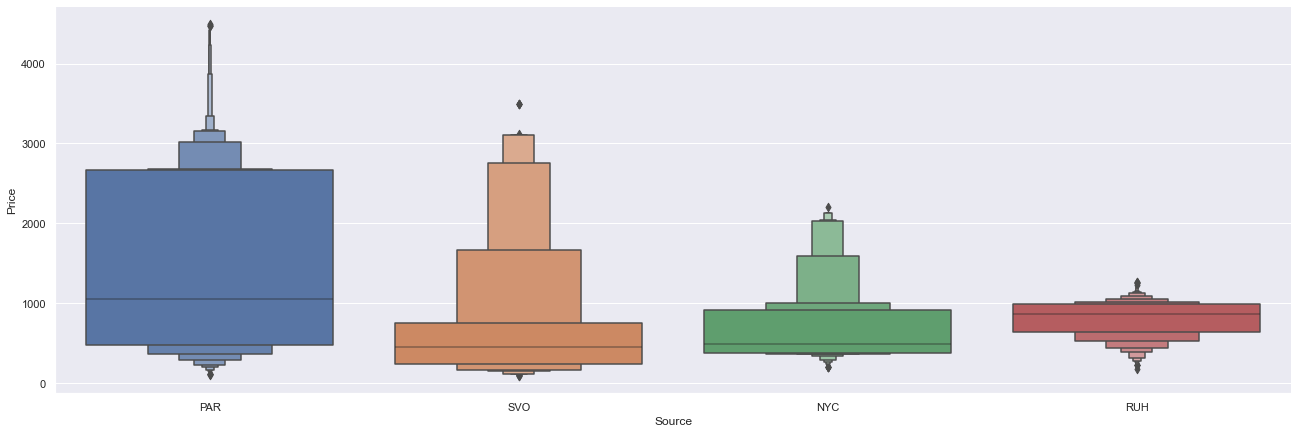

In [15]:
# source vs price
sns.catplot(y = "Price", x= "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [16]:
# performing OneHotEncoding on Source since it's nominal categorical data  
source =df[["Source"]]
source =pd.get_dummies(source, drop_first=True)
source.head()

,Source_PAR,Source_RUH,Source_SVO
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [17]:
# destination
df["Destination"].value_counts()

NYC    24926
RUH    11046
PAR     8042
SVO     6083
Name: Destination, dtype: int64

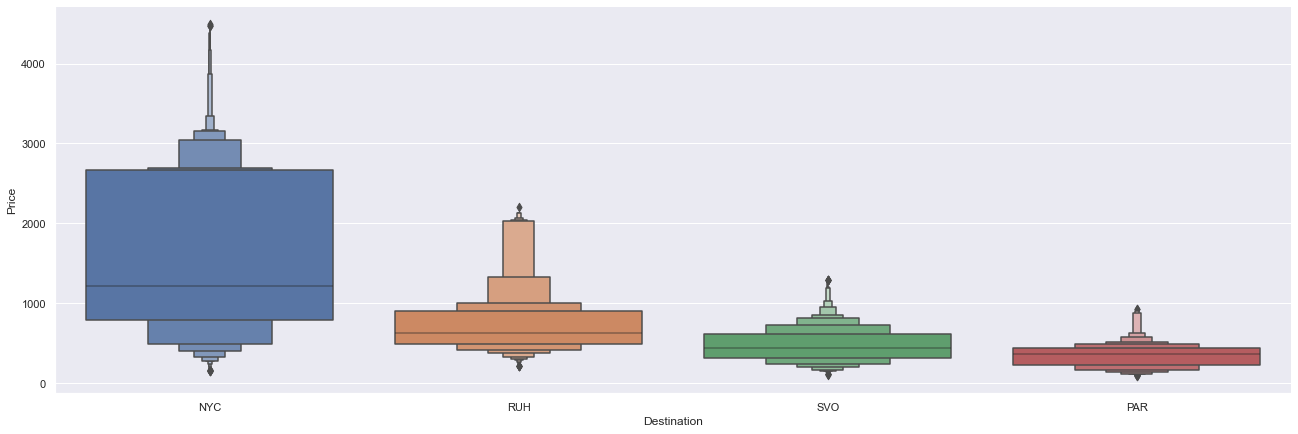

In [18]:
# destination vs price
sns.catplot(y = "Price", x= "Destination", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)

In [19]:
# performing OneHotEncoding on Destination since it's nominal categorical data
destination = df[["Destination"]]
destination = pd.get_dummies(destination, drop_first=True)
destination.head()

,Destination_PAR,Destination_RUH,Destination_SVO
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [20]:
# total stops
print(df["Total stops"].value_counts())
df["Total stops"].unique()

1 stop      27466
2 stops     18665
3 stops      1988
nonstop      1978
Name: Total stops, dtype: int64


array(['1 stop ', '2 stops ', 'nonstop ', '3 stops '], dtype=object)

In [21]:
# performing LabelEncoder on Total stops since it's ordinal categorical data
df.replace({"nonstop ":0, "1 stop ": 1, "2 stops ": 2, "3 stops ":3}, inplace=True)

In [22]:
final_df = pd.concat([df,source,destination], axis=1).reset_index(drop = True)

In [23]:
final_df

,Source,Destination,Duration,Total stops,Price,Date,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,PAR,NYC,770,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
1,PAR,NYC,770,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
2,PAR,NYC,810,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
3,PAR,NYC,890,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
4,PAR,NYC,1030,1,379.47,2022-02-01,441.343760,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50092,NYC,RUH,1300,2,930.40,2022-04-13,838.732500,0,0,0,0,1,0
50093,NYC,RUH,1420,2,1018.40,2022-04-13,1972.813714,0,0,0,0,1,0
50094,NYC,RUH,1415,2,1049.87,2022-04-13,1133.548015,0,0,0,0,1,0
50095,NYC,RUH,1100,2,1053.60,2022-04-13,1023.900221,0,0,0,0,1,0


In [24]:
# drop date since it'll not be used as a feature
final_df.drop(["Source","Destination","Date"], axis=1, inplace=True)

In [25]:
final_df

,Duration,Total stops,Price,Average Price,Source_PAR,Source_RUH,Source_SVO,Destination_PAR,Destination_RUH,Destination_SVO
0,770,1,379.47,441.343760,1,0,0,0,0,0
1,770,1,379.47,441.343760,1,0,0,0,0,0
2,810,1,379.47,441.343760,1,0,0,0,0,0
3,890,1,379.47,441.343760,1,0,0,0,0,0
4,1030,1,379.47,441.343760,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
50092,1300,2,930.40,838.732500,0,0,0,0,1,0
50093,1420,2,1018.40,1972.813714,0,0,0,0,1,0
50094,1415,2,1049.87,1133.548015,0,0,0,0,1,0
50095,1100,2,1053.60,1023.900221,0,0,0,0,1,0


In [26]:
final_df.shape

(50097, 10)

In [27]:
final_df.isnull().sum()

Duration           0
Total stops        0
Price              0
Average Price      0
Source_PAR         0
Source_RUH         0
Source_SVO         0
Destination_PAR    0
Destination_RUH    0
Destination_SVO    0
dtype: int64

## Features: <a class="anchor" id="features"></a>

#### After constructing the final dataframe with all numerical values, now we can analyze the features that will be used for the regressions models

In [28]:
final_df.columns

Index(['Duration', 'Total stops', 'Price', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO'],
      dtype='object')

In [29]:
X = final_df[['Duration', 'Total stops', 'Average Price', 'Source_PAR',
       'Source_RUH', 'Source_SVO', 'Destination_PAR', 'Destination_RUH',
       'Destination_SVO']]

y = final_df["Price"]

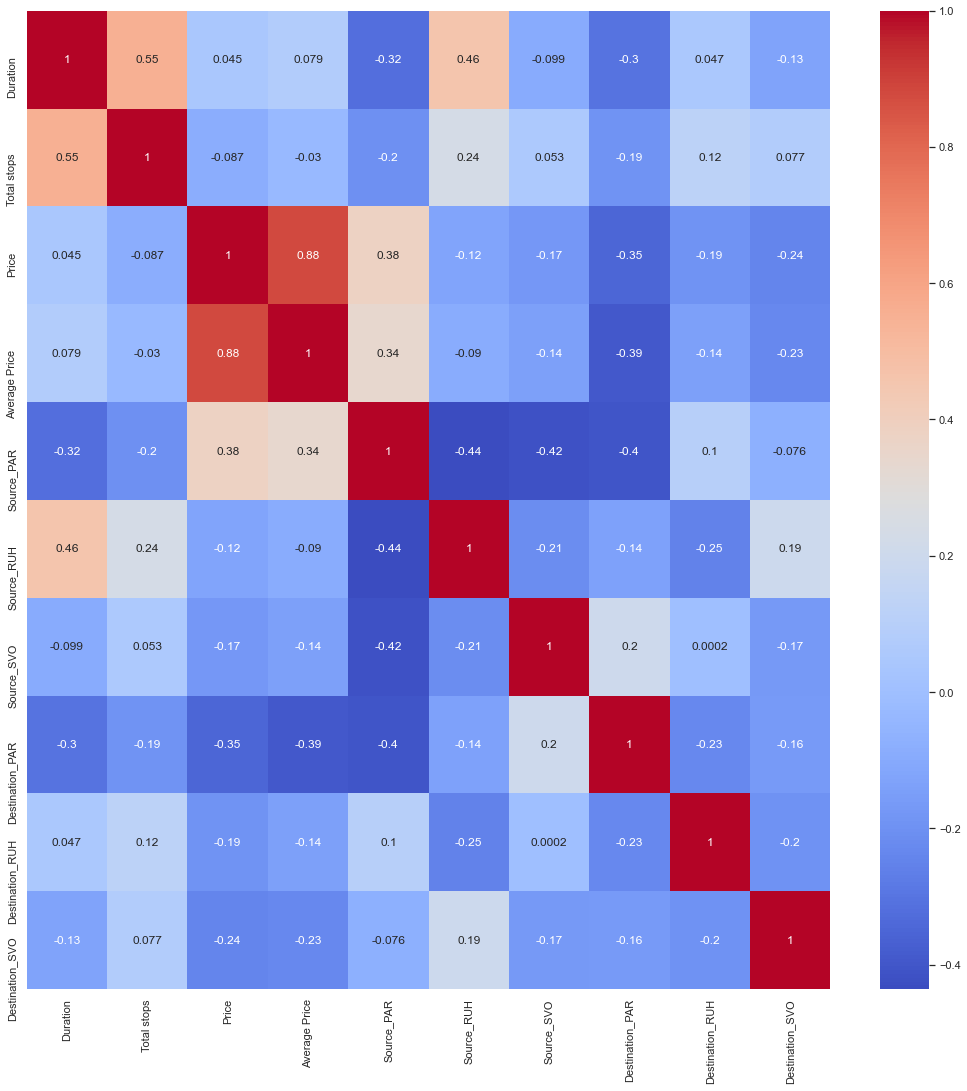

In [30]:
plt.figure(figsize = (18,18))

sns.heatmap(final_df.corr(),annot= True, cmap = "coolwarm")

plt.show()

In [31]:
# getting feature importance to the target variable "Price".
selection =ExtraTreesRegressor()
selection.fit(X,y)
selection.feature_importances_

array([0.03945716, 0.01524215, 0.75053115, 0.08639322, 0.0095365 ,
       0.01457306, 0.01948406, 0.05107754, 0.01370516])

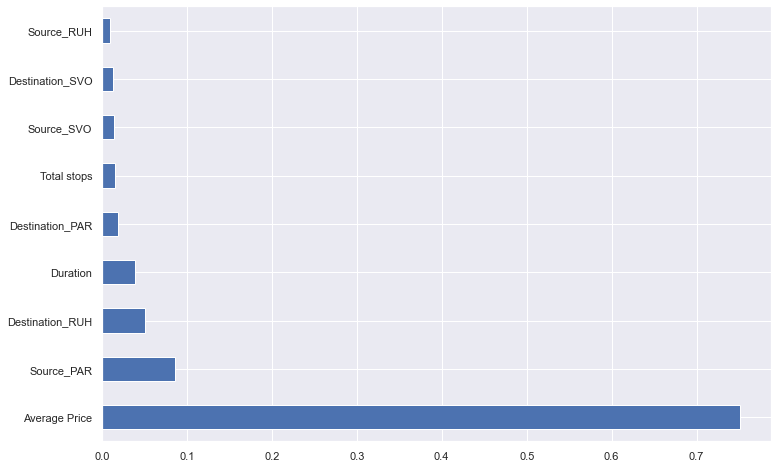

In [32]:
# plotting graph of important features
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_,index = X.columns)
feat_importances.nlargest(20).plot(kind="barh")
plt.show()

## Modeling: <a class="anchor" id="modeling"></a>

### Splitting the data

In [33]:
# 60% Train - 20% Val - 20% Test

X_train_or, X_test, y_train_or, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size=0.25)

### Defining a function to get metrics for val set

In [34]:
def get_metrics(model):
    print(f'Train score {model.score(X_train, y_train)}')
    print(f'Val score {model.score(X_val, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val))))

### Baseline Linear Regression

In [35]:
lr = LinearRegression()
lr.fit(X_train, y_train)
score = lr.score(X_val, y_val)
get_metrics(lr)

Train score 0.8042075862012158
Val score 0.799091747676185
MAE: 223.54163691510288
MSE: 146405.03815700335
RMSE: 382.6291130546699


### Polynomial 

In [36]:
for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("-"*20)
    print("Degree", degree)
    get_metrics(poly)

--------------------
Degree 1
Train score 0.8042075862012158
Val score 0.799091747676185
MAE: 223.54163691511357
MSE: 146405.03815700338
RMSE: 382.6291130546699
--------------------
Degree 2
Train score 0.8577386713465396
Val score 0.8531428258957733
MAE: 177.1799418362886
MSE: 107017.1579796794
RMSE: 327.13477036181797
--------------------
Degree 3
Train score 0.8770463980295427
Val score 0.8713160624597465
MAE: 157.8099398786702
MSE: 93774.03151866965
RMSE: 306.22545863900615
--------------------
Degree 4
Train score 0.8824208957179241
Val score 0.87265418477357
MAE: 151.2948946355236
MSE: 92798.92051079363
RMSE: 304.62915243094125
--------------------
Degree 5
Train score 0.8880616051476802
Val score 0.8674999117398803
MAE: 149.52430861840355
MSE: 96554.92122973234
RMSE: 310.73287761312343


### Lasso

In [37]:
lasso_model = Lasso()
lasso_model.fit(X_train, y_train)
get_metrics(lasso_model)

Train score 0.8040152793427423
Val score 0.7987507794705604
MAE: 222.16720773144954
MSE: 146653.50711025644
RMSE: 382.95366183163264


### Ridge

In [38]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
get_metrics(ridge_model)

Train score 0.8042075716390646
Val score 0.7990906250589928
MAE: 223.52834362175253
MSE: 146405.85622600233
RMSE: 382.6301820635721


### ElasticNet

In [39]:
EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train, y_train)
EN_model.score(X_val, y_val)
get_metrics(EN_model)

Train score 0.7903793999331932
Val score 0.7841345931483472
MAE: 224.07477501051082
MSE: 157304.55449861614
RMSE: 396.6163820351047


### Random Forest

In [40]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
get_metrics(rf)

Train score 0.9629081092945282
Val score 0.9438711040124448
MAE: 62.48641145124633
MSE: 40902.01902470289
RMSE: 202.2424758172795


### Feature Scaling

In [41]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [42]:
# function to get metrics for scaled features
def scaled_metrics(model):
    print(f'Train score {model.score(X_train_scaled, y_train)}')
    print(f'Val score {model.score(X_val_scaled, y_val)}')
    print("MAE:" , metrics.mean_absolute_error(y_val,model.predict(X_val_scaled)))
    print("MSE:" , metrics.mean_squared_error(y_val,model.predict(X_val_scaled)))
    print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_val,model.predict(X_val_scaled))))

    
## Baseline: Linear Regression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
score = lr.score(X_val_scaled, y_val)
print("LR")
scaled_metrics(lr)
print("-"*50)

## Polynomial

for degree in [1,2,3,4,5]:
    poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly.fit(X_train, y_train)
    print("Polynomial - Degree", degree)
    scaled_metrics(poly)
    print("-"*50)

## Lasso

lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
print("Lasso")
scaled_metrics(lasso_model)
print("-"*50)

## Ridge

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
print("Ridge")
scaled_metrics(ridge_model)
print("-"*50)

## ElasticNet

EN_model = ElasticNet(alpha=1)
EN_model.fit(X_train_scaled, y_train)
EN_model.score(X_val_scaled, y_val)
print("ElasticNet")
scaled_metrics(EN_model)
print("-"*50)

## Random Forest
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print("Random Forest")
scaled_metrics(rf)

LR
Train score 0.8042075862012158
Val score 0.7990917476761851
MAE: 223.54163691510374
MSE: 146405.03815700332
RMSE: 382.62911305466986
--------------------------------------------------
Polynomial - Degree 1
Train score -0.37890410229121807
Val score -0.38037765123483114
MAE: 782.3098033678265
MSE: 1005903.1441594723
RMSE: 1002.9472290003459
--------------------------------------------------
Polynomial - Degree 2
Train score -6.61586993100154
Val score -6.55759560765061
MAE: 1791.813053502219
MSE: 5507340.094372675
RMSE: 2346.7722715194745
--------------------------------------------------
Polynomial - Degree 3
Train score -6.983013766507188
Val score -7.132851978264544
MAE: 1948.3751148205017
MSE: 5926538.558923796
RMSE: 2434.4483068908644
--------------------------------------------------
Polynomial - Degree 4
Train score -79.55275917975915
Val score -79.17259571110154
MAE: 5399.783631499363
MSE: 58423045.337687604
RMSE: 7643.496931227722
--------------------------------------------

#### Feature scaling was of no use, it did not improve anything.



Random Forest performs well

In [43]:
# retraining the random forest model on train + val, and scoring on test

X_train_val = pd.concat([X_train,X_val])
y_train_val = pd.concat([y_train,y_val])

rf = RandomForestRegressor()
rf.fit(X_train_val,y_train_val)

print(f'Train score {rf.score(X_train_val, y_train_val)}')
print(f'Test score {rf.score(X_test, y_test)}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf.predict(X_test))))

Train score 0.9619101266861599
Test score 0.9518679598508045
MAE: 59.23628255083474
MSE: 36370.21673665235
RMSE: 190.70977095223083


In [44]:
y_train_val_pred = rf.predict(X_train_val)
y_test_pred = rf.predict(X_test)

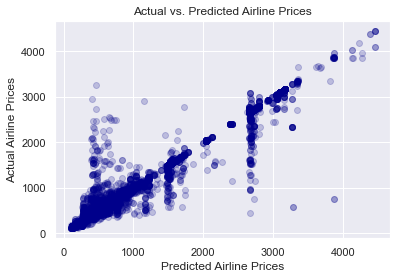

In [45]:
plt.scatter(y_test,y_test_pred,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

### Hyperparameter Tuning

In [46]:
# randomized search CV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [47]:
# create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [48]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, n_jobs = 1)

In [49]:
rf_random.fit(X_train_val,y_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1100; total time=  29.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1100; total time=  27.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1100; total time=  28.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1100; total time=  25.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1100; total time=  26.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1100; total time=  12.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1100; total time=  11.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_esti

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [50]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [51]:
prediction = rf_random.predict(X_test)

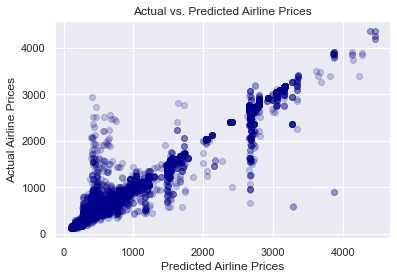

In [52]:
plt.scatter(y_test,prediction,alpha =0.2,color="DarkBlue")
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');

In [53]:
print("MAE:" , metrics.mean_absolute_error(y_test,prediction))
print("MSE:" , metrics.mean_squared_error(y_test,prediction))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE: 65.66816104723297
MSE: 36406.94008246547
RMSE: 190.80602737457082


#### Therefore, hyperparameter tuning did not improve the model

In [59]:
test_df = pd.DataFrame({
    "Predicted Price" : rf.predict(X_test),
    "Actual Price" : y_test,
}).reset_index(drop = True)

test_df

,Predicted Price,Actual Price
0,3002.290930,2984.00
1,1494.376977,1495.20
2,589.927472,578.13
3,723.167406,719.20
4,976.554543,975.73
...,...,...
10015,461.165757,419.20
10016,415.878484,385.33
10017,128.967545,129.07
10018,1534.410700,1529.60


## Saving The Final Model: <a class="anchor" id="model"></a>

In [60]:
# save the model
file = open('rf_flight_prediction.pkl', 'wb')
pkl.dump(rf, file)

In [61]:
# open the model
model = open('rf_flight_prediction.pkl','rb')
rf_flight_prediction = pkl.load(model)

In [62]:
print(f'R2 score {metrics.r2_score(y_test,rf_flight_prediction.predict(X_test))}')
print("MAE:" , metrics.mean_absolute_error(y_test,rf_flight_prediction.predict(X_test)))
print("MSE:" , metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test)))
print("RMSE:" , np.sqrt(metrics.mean_squared_error(y_test,rf_flight_prediction.predict(X_test))))

R2 score 0.9518679598508045
MAE: 59.23628255083474
MSE: 36370.21673665235
RMSE: 190.70977095223083


### predicted flight ticket prices within around  ≈ $61.87